In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

In [ ]:
coloc_df = pd.read_csv('data/All_Colocalization_Scores.csv')
coloc_df

,Subject_ID,Treatment_Status,Task_1,Task_2,Colocalization_Score
0,1182412B,Treated,Deoxyguanosine triphosphate synthesis (dGTP),Cytidine triphosphate synthesis (CTP),35.619280
1,1182412B,Treated,Deoxyguanosine triphosphate synthesis (dGTP),Glutamate synthesis,1.926232
2,1182412B,Treated,Deoxyguanosine triphosphate synthesis (dGTP),Deoxycytidine triphosphate synthesis (dCTP),35.619280
3,1182412B,Treated,Deoxyguanosine triphosphate synthesis (dGTP),Conversion of glutamate to glutamine,-2.978208
4,1182412B,Treated,Deoxyguanosine triphosphate synthesis (dGTP),Deoxyadenosine triphosphate synthesis (dATP),35.619280
...,...,...,...,...,...
1984,120161,Untreated,Synthesis of kynate from tryptophan,ATP generation from glucose (hypoxic condition...,1.648780
1985,120161,Untreated,Synthesis of kynate from tryptophan,Deoxyuridine triphosphate synthesis (dUTP),0.363863
1986,120161,Untreated,Synthesis of anthranilate from tryptophan,ATP generation from glucose (hypoxic condition...,1.648780
1987,120161,Untreated,Synthesis of anthranilate from tryptophan,Deoxyuridine triphosphate synthesis (dUTP),0.363863


### Diff Analysis

In [22]:
df = coloc_df.copy()

pair_group = df.groupby(["Task_1", "Task_2", "Treatment_Status"])["Colocalization_Score"].mean()

pair_pivot = pair_group.unstack()

pair_pivot["Delta"] = pair_pivot["Treated"] - pair_pivot["Untreated"]

pair_pivot = pair_pivot.reset_index()

pair_pivot.to_csv("Differential_Task_Interaction_Table.csv", index=False)

pair_pivot.head()


Treatment_Status,Task_1,Task_2,Treated,Untreated,Delta
0,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic condition...,11.801559,10.679186,1.122374
1,(R)-3-Hydroxybutanoate synthesis,Acetoacetate synthesis,11.801559,10.679186,1.122374
2,(R)-3-Hydroxybutanoate synthesis,Deoxyuridine triphosphate synthesis (dUTP),0.986659,0.940679,0.045981
3,(R)-3-Hydroxybutanoate synthesis,Synthesis of L-kynurenine from tryptophan,0.556691,0.095802,0.460889
4,(R)-3-Hydroxybutanoate synthesis,Synthesis of anthranilate from tryptophan,0.556691,0.095802,0.460889


/tmp/ipykernel_557846/1103238519.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


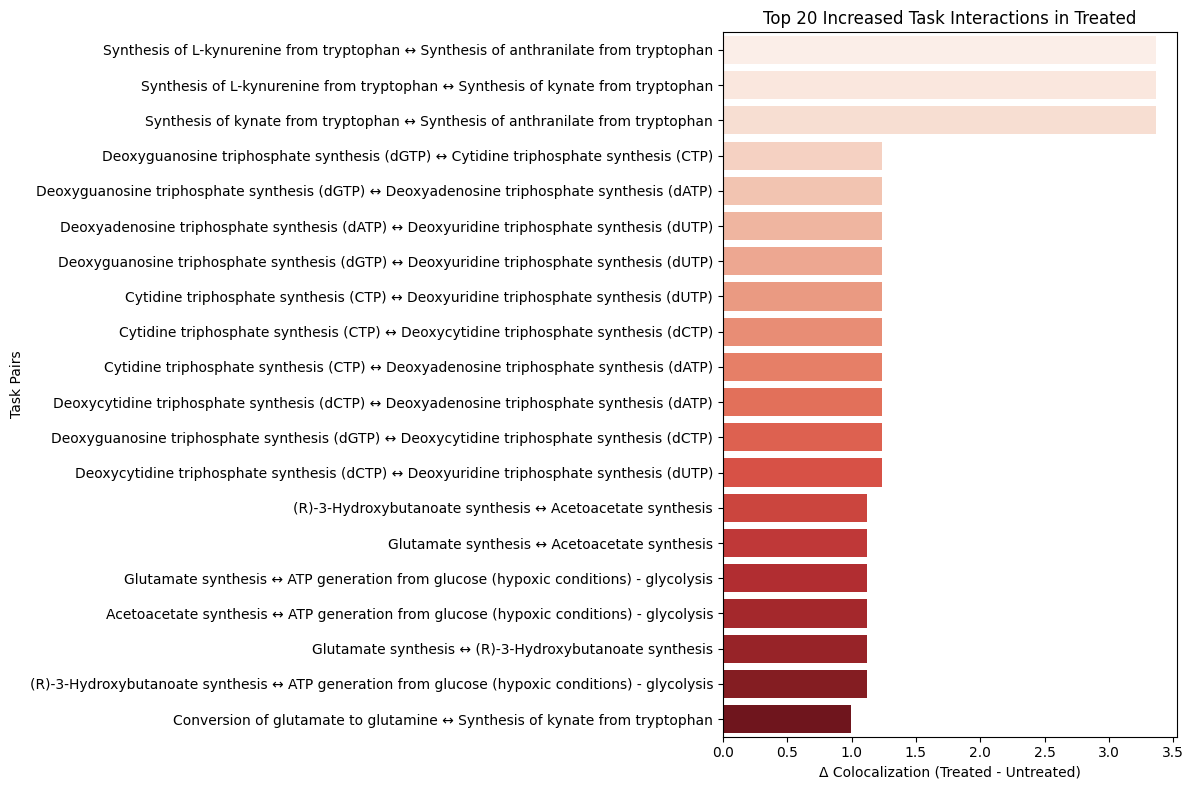

In [24]:
top_pos = pair_pivot.sort_values("Delta", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_pos,
    y=top_pos["Task_1"] + " ↔ " + top_pos["Task_2"],
    x="Delta",
    palette="Reds"
)

plt.title("Top 20 Increased Task Interactions in Treated")
plt.xlabel("Δ Colocalization (Treated - Untreated)")
plt.ylabel("Task Pairs")
plt.tight_layout()
plt.show()


/tmp/ipykernel_557846/3653182518.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


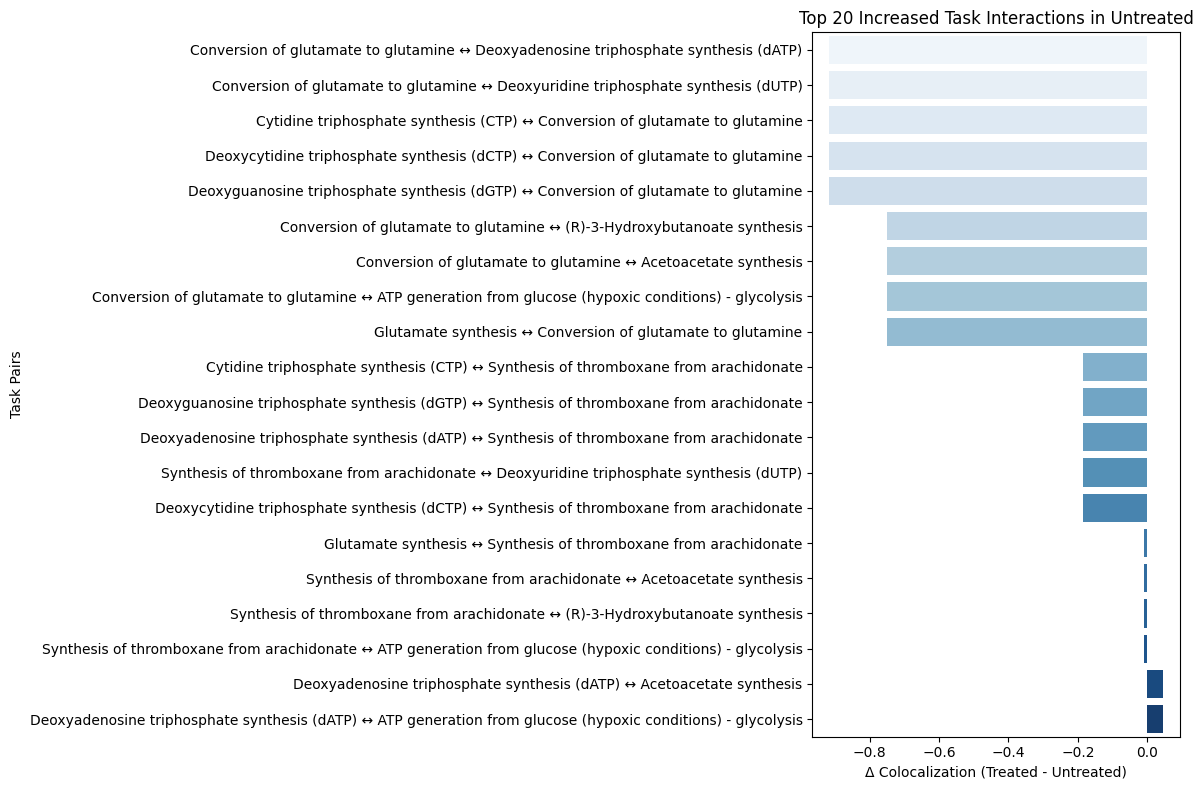

In [25]:
top_neg = pair_pivot.sort_values("Delta", ascending=True).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_neg,
    y=top_neg["Task_1"] + " ↔ " + top_neg["Task_2"],
    x="Delta",
    palette="Blues"
)

plt.title("Top 20 Increased Task Interactions in Untreated")
plt.xlabel("Δ Colocalization (Treated - Untreated)")
plt.ylabel("Task Pairs")
plt.tight_layout()
plt.show()

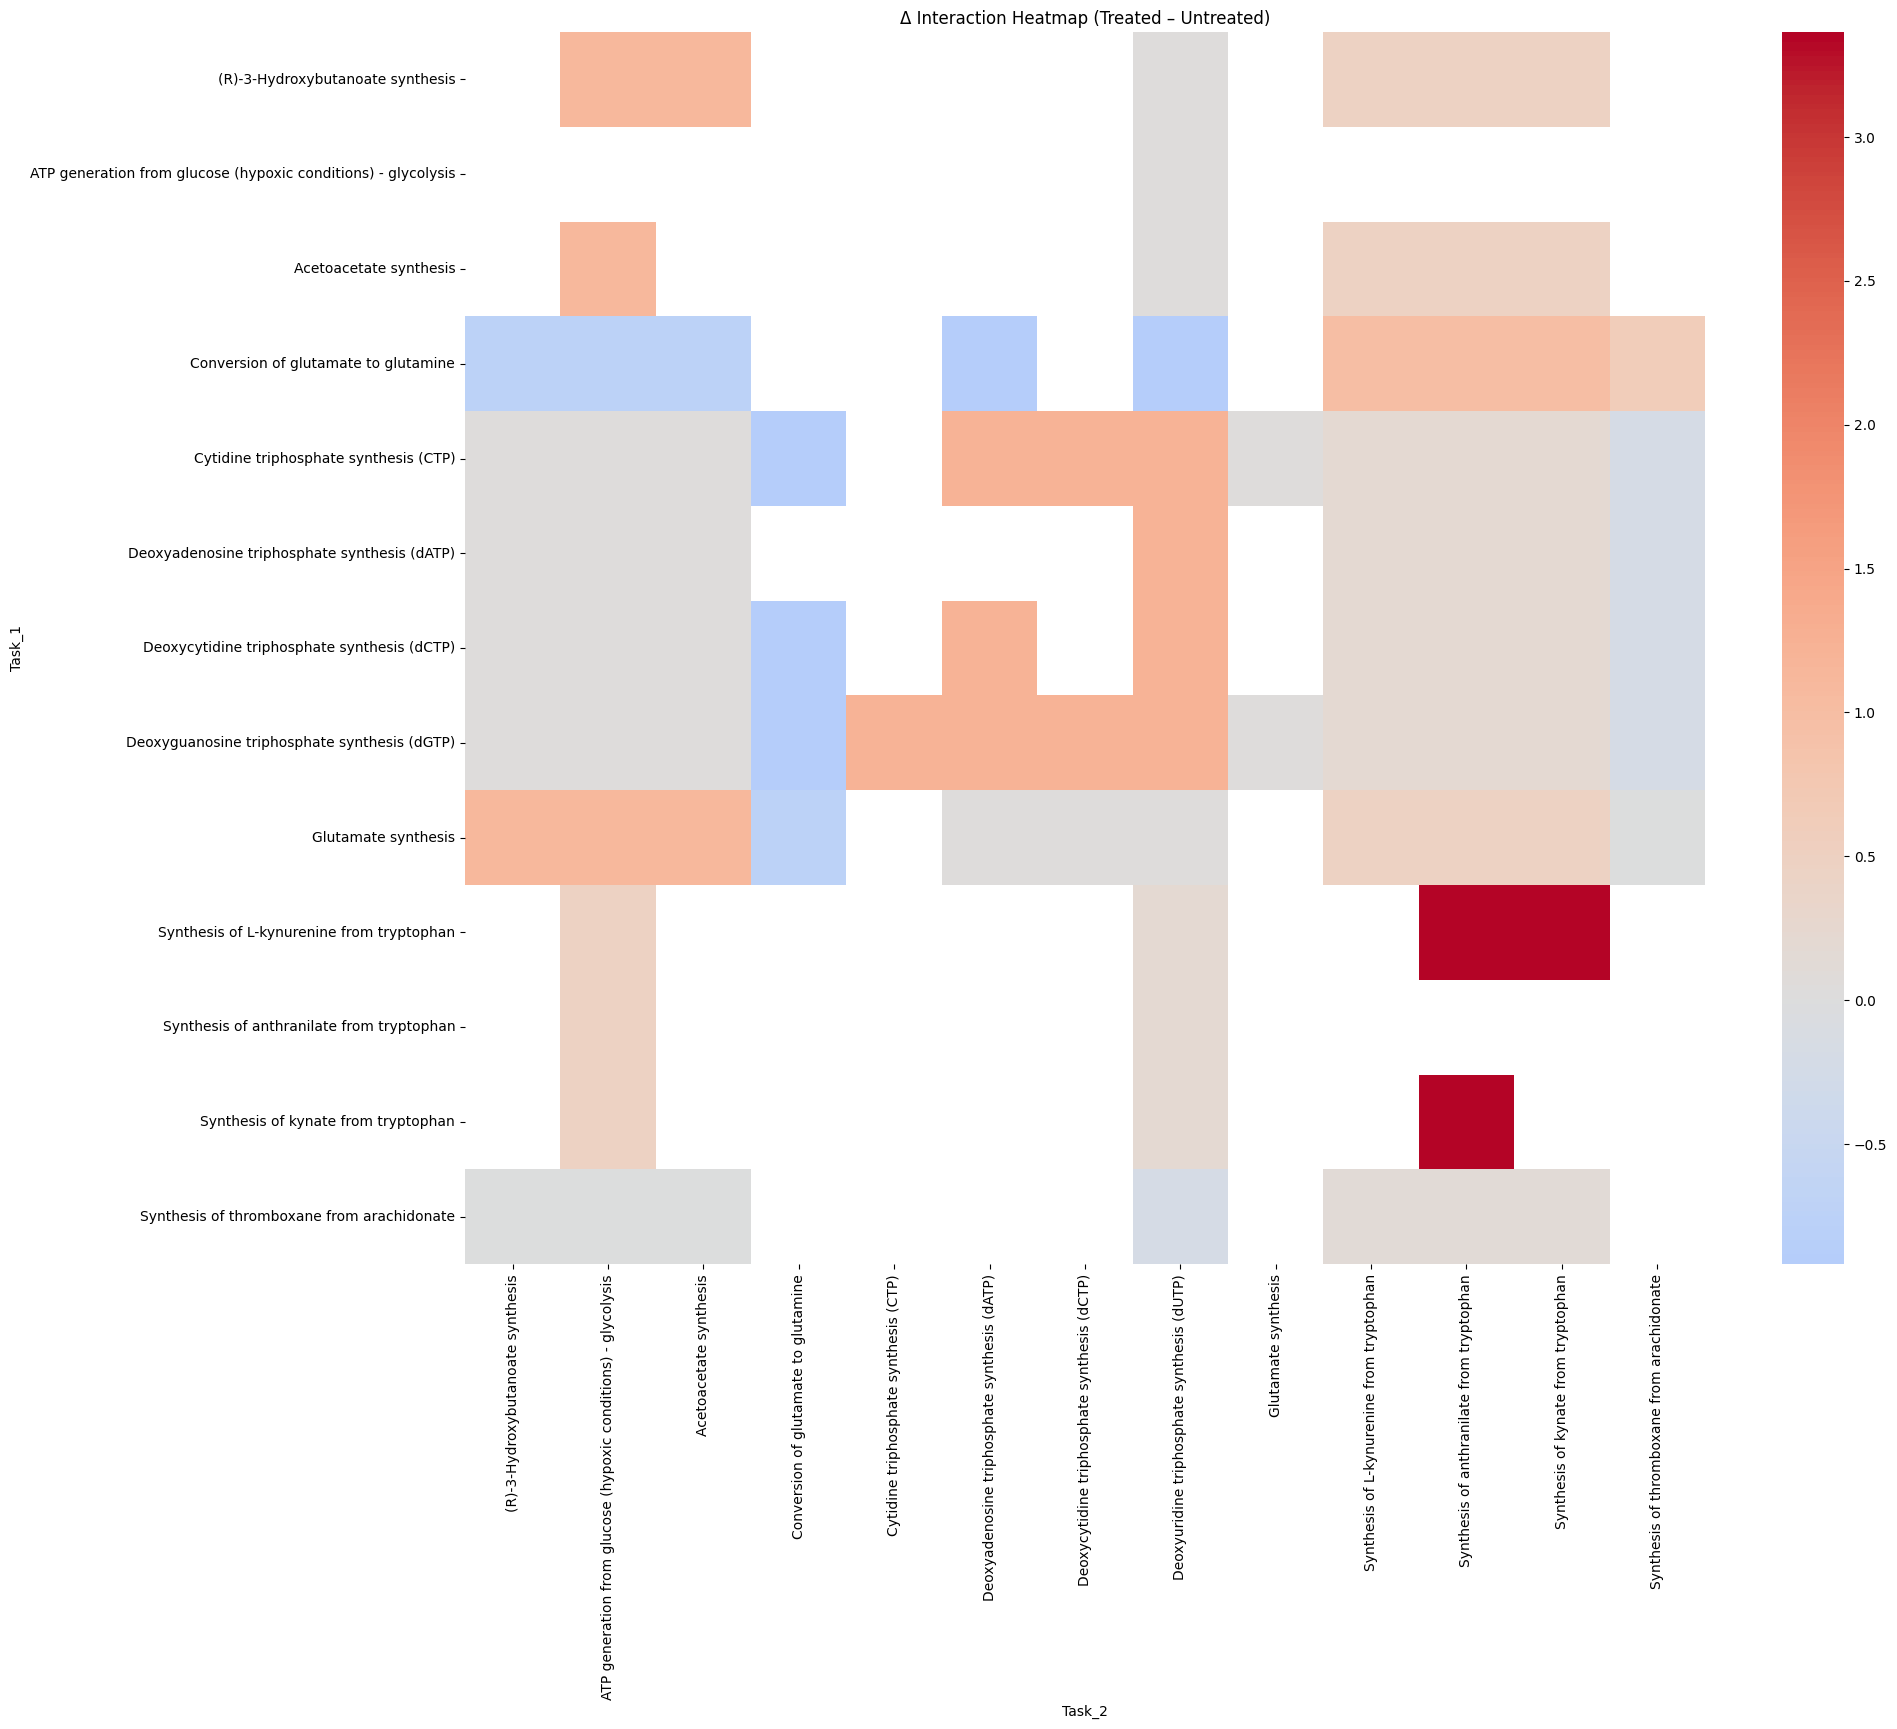

In [26]:
mat = pair_pivot.pivot(
    index="Task_1",
    columns="Task_2",
    values="Delta"
)

plt.figure(figsize=(20, 16))
sns.heatmap(mat, cmap="coolwarm", center=0)
plt.title("Δ Interaction Heatmap (Treated – Untreated)")
plt.xlabel("Task_2")
plt.ylabel("Task_1")
plt.show()


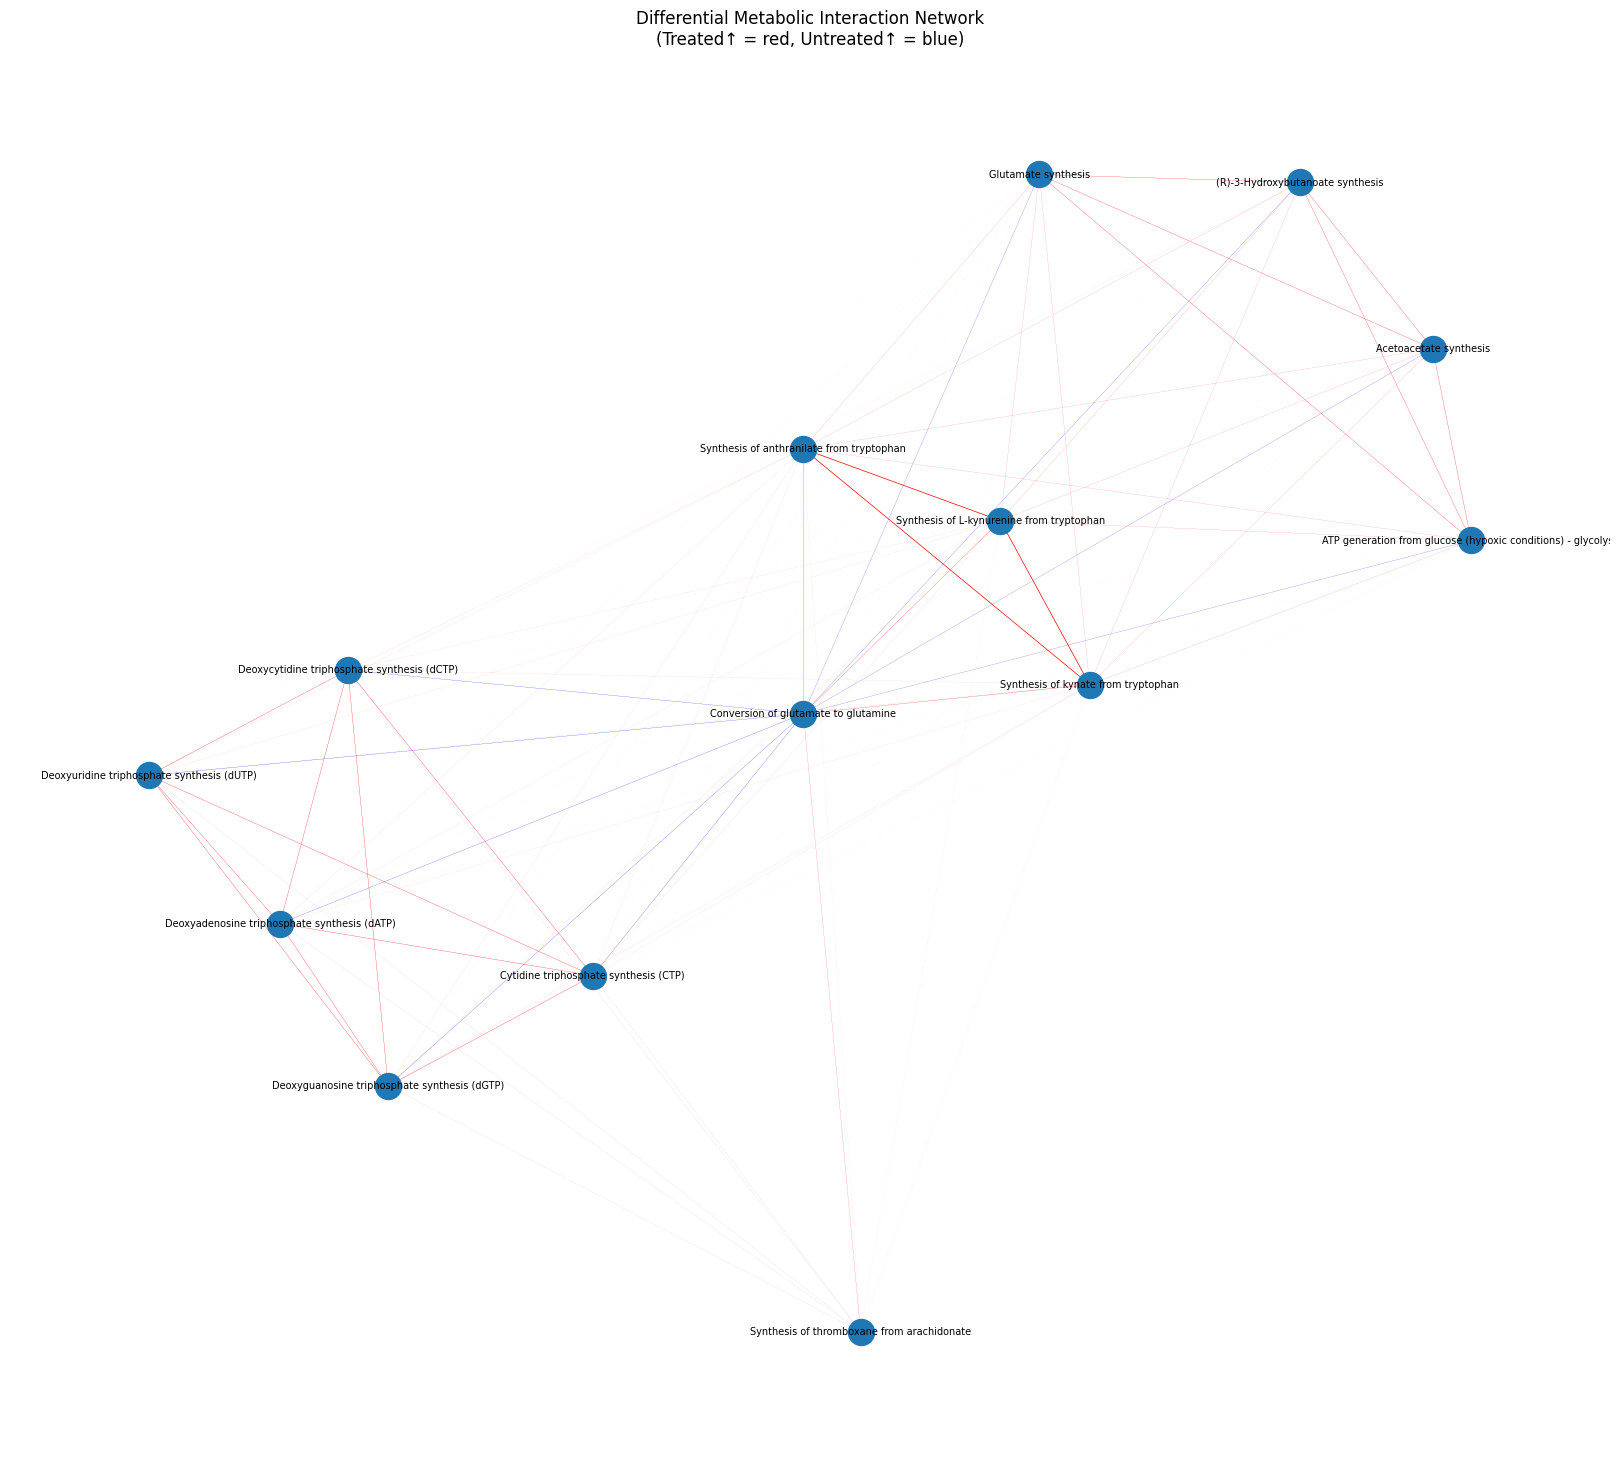

In [28]:
G = nx.Graph()

for _, row in pair_pivot.iterrows():
    t1, t2, delta = row["Task_1"], row["Task_2"], row["Delta"]
    if pd.isna(delta):
        continue
    G.add_edge(
        t1, t2,
        weight=abs(delta),
        color="red" if delta > 0 else "blue"
    )

pos = nx.spring_layout(G, seed=42)

edges = G.edges()
colors = [G[u][v]["color"] for u, v in edges]
weights = [G[u][v]["weight"] for u, v in edges]

plt.figure(figsize=(16, 14))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=350,
    edge_color=colors,
    width=[w * 0.15 for w in weights],
    font_size=7
)
plt.title("Differential Metabolic Interaction Network\n(Treated↑ = red, Untreated↑ = blue)")
plt.show()


## LogFC Analysis

In [30]:
df = coloc_df.copy()

pair_group = df.groupby(["Task_1","Task_2","Treatment_Status"])["Colocalization_Score"].mean()
pivot = pair_group.unstack()

T = pivot["Treated"]
U = pivot["Untreated"]

# Signed Log Fold Change
pivot["logFC"] = np.sign(T - U) * np.log2((abs(T) + 1e-6) / (abs(U) + 1e-6))

pivot = pivot.reset_index()
pivot.head()

Treatment_Status,Task_1,Task_2,Treated,Untreated,logFC
0,(R)-3-Hydroxybutanoate synthesis,ATP generation from glucose (hypoxic condition...,11.801559,10.679186,0.144176
1,(R)-3-Hydroxybutanoate synthesis,Acetoacetate synthesis,11.801559,10.679186,0.144176
2,(R)-3-Hydroxybutanoate synthesis,Deoxyuridine triphosphate synthesis (dUTP),0.986659,0.940679,0.068850
3,(R)-3-Hydroxybutanoate synthesis,Synthesis of L-kynurenine from tryptophan,0.556691,0.095802,2.538739
4,(R)-3-Hydroxybutanoate synthesis,Synthesis of anthranilate from tryptophan,0.556691,0.095802,2.538739


/tmp/ipykernel_557846/4151850100.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


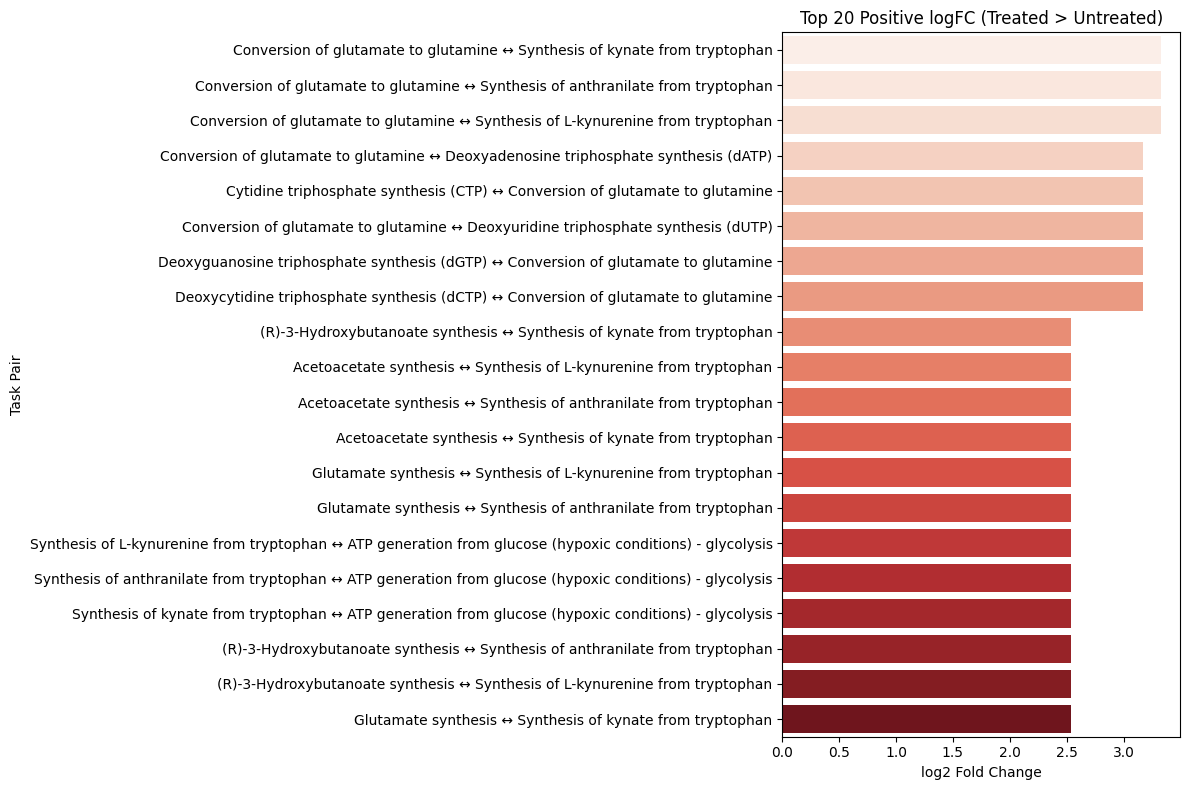

In [ ]:
top_up = pivot.sort_values("logFC", ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_up,
    y=top_up["Task_1"] + " ↔ " + top_up["Task_2"],
    x="logFC",
    palette="Reds"
)
plt.title("Top 20 Positive logFC (Treated > Untreated)")
plt.xlabel("log2 Fold Change")
plt.ylabel("Task Pair")
plt.tight_layout()
plt.show()


/tmp/ipykernel_557846/3526225491.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


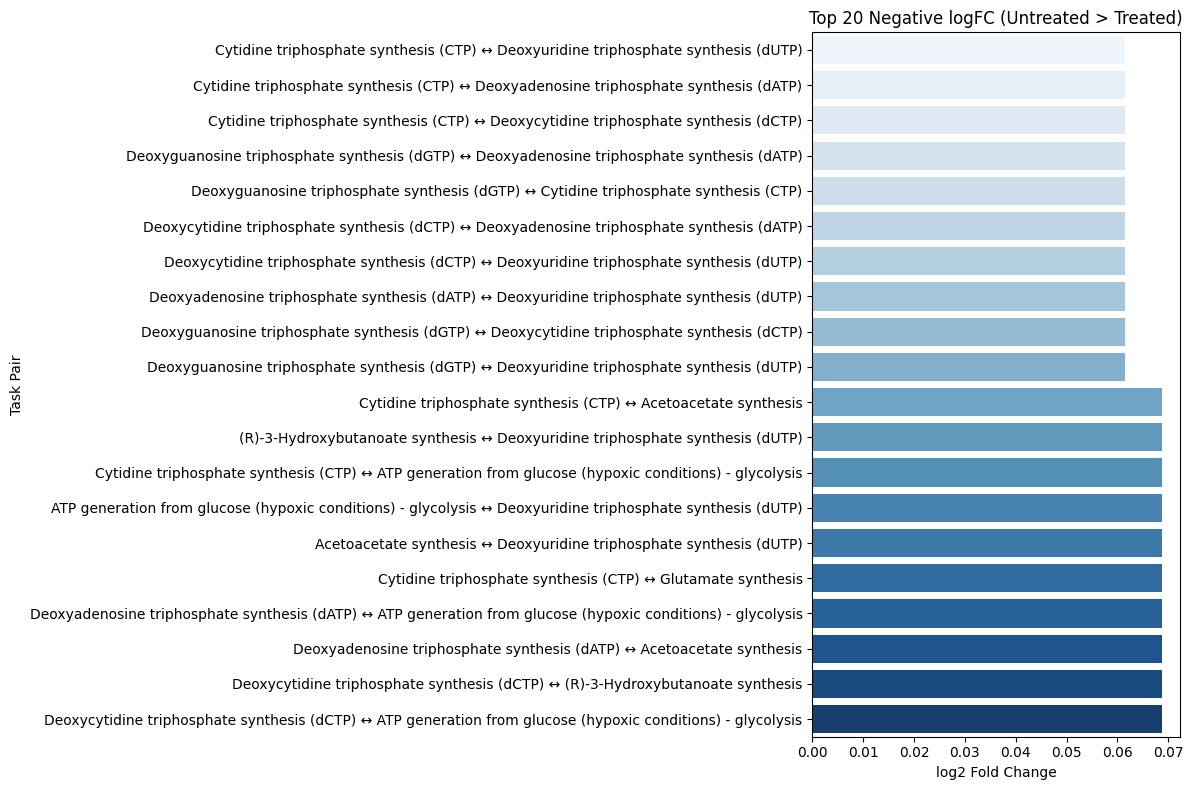

In [32]:
top_down = pivot.sort_values("logFC", ascending=True).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_down,
    y=top_down["Task_1"] + " ↔ " + top_down["Task_2"],
    x="logFC",
    palette="Blues"
)
plt.title("Top 20 Negative logFC (Untreated > Treated)")
plt.xlabel("log2 Fold Change")
plt.ylabel("Task Pair")
plt.tight_layout()
plt.show()


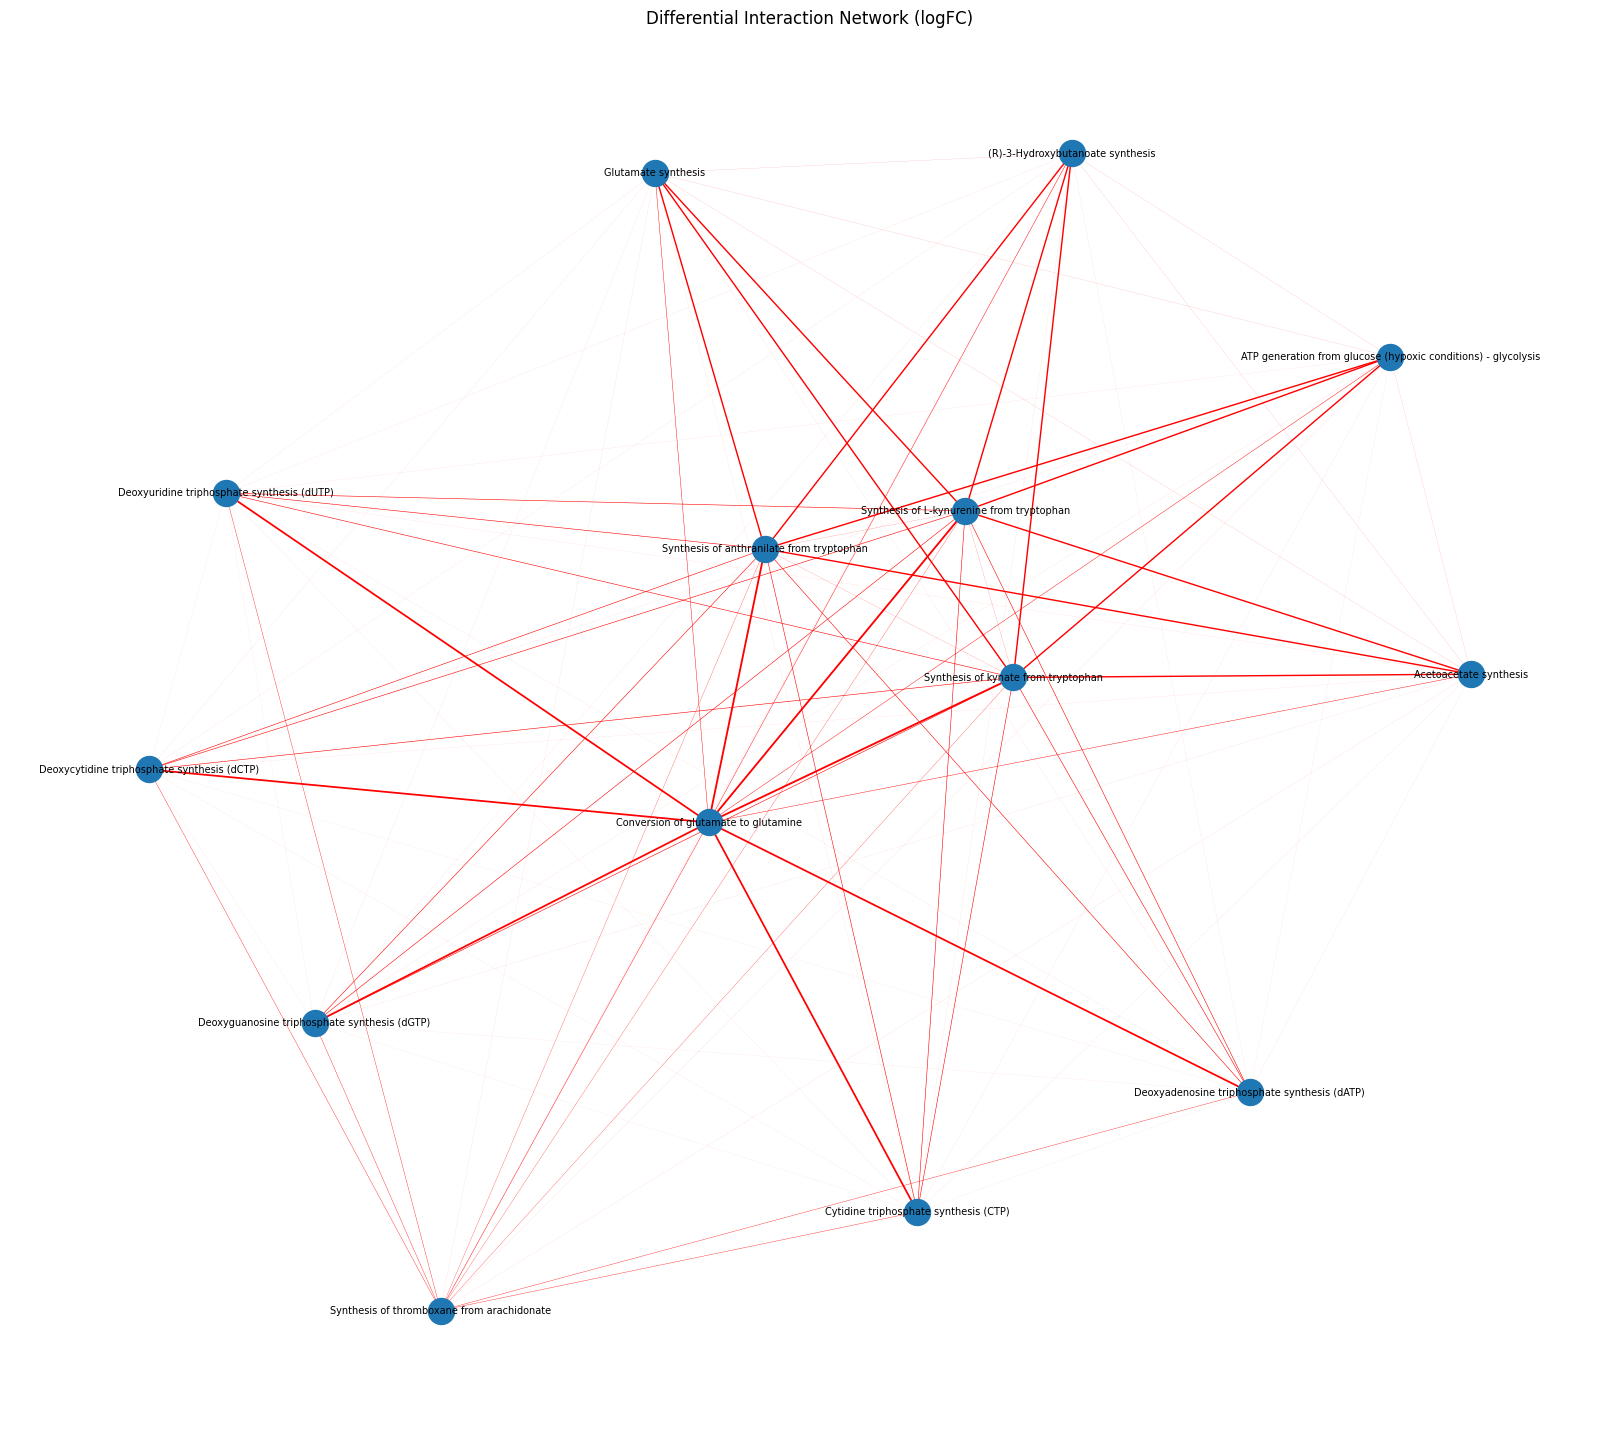

In [33]:
G = nx.Graph()

for _, r in pivot.iterrows():
    t1, t2, v = r["Task_1"], r["Task_2"], r["logFC"]
    if pd.isna(v): 
        continue
    G.add_edge(
        t1, t2,
        weight=abs(v),
        color="red" if v > 0 else "blue"
    )

pos = nx.spring_layout(G, seed=42)

edges = G.edges()
colors = [G[u][v]["color"] for u, v in edges]
weights = [G[u][v]["weight"] for u, v in edges]

plt.figure(figsize=(16, 14))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=350,
    edge_color=colors,
    width=[w * 0.4 for w in weights],
    font_size=7
)
plt.title("Differential Interaction Network (logFC)")
plt.show()


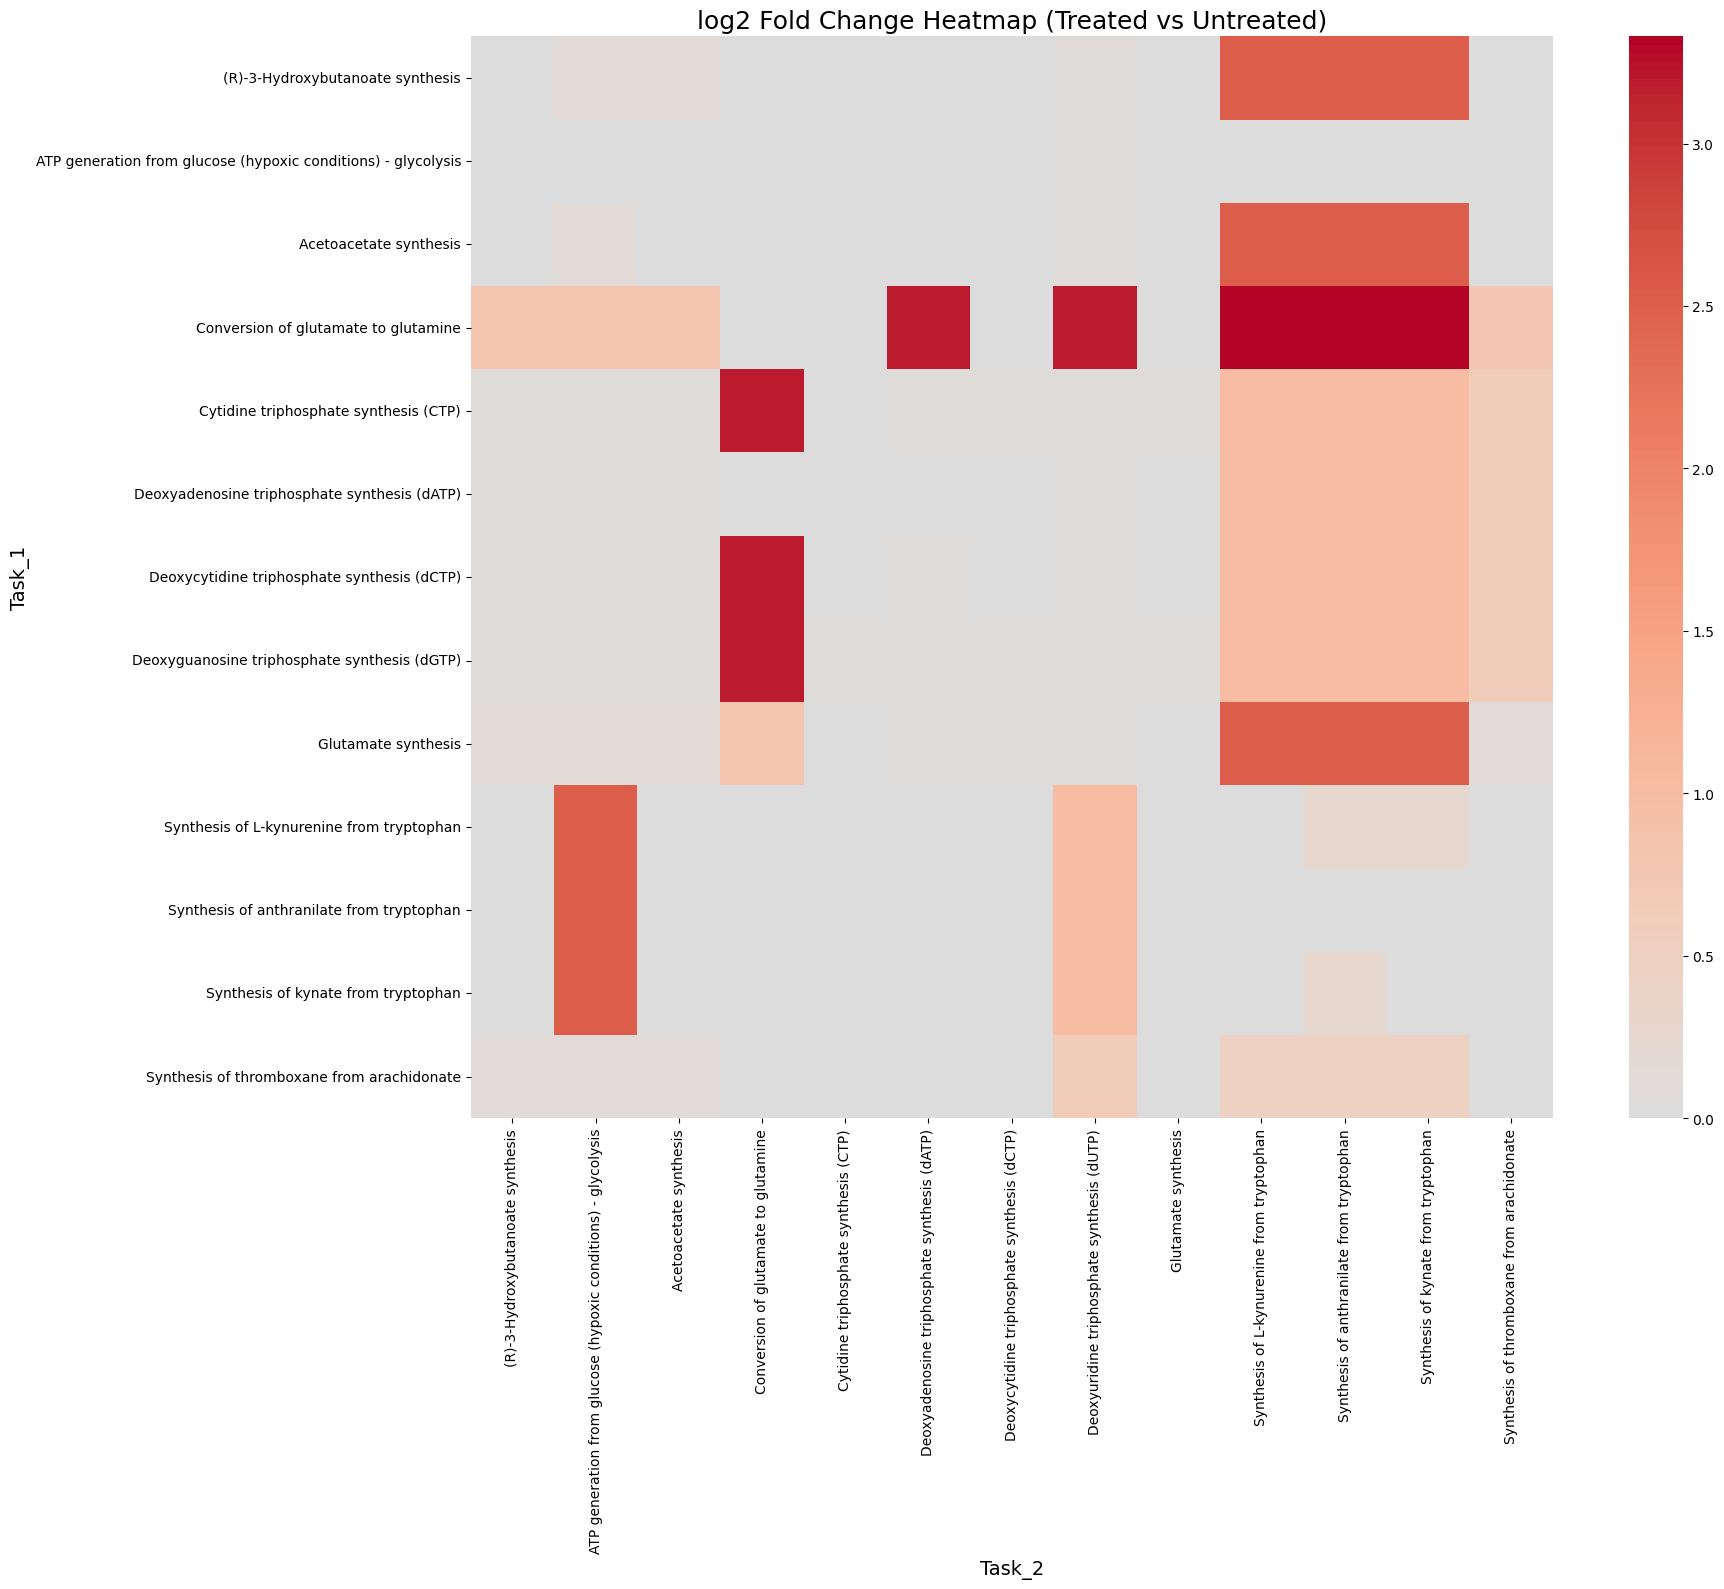

In [34]:
mat_logfc = pivot.pivot(
    index="Task_1",
    columns="Task_2",
    values="logFC"
).fillna(0) 

plt.figure(figsize=(20, 16))
sns.heatmap(
    mat_logfc, 
    cmap="coolwarm", 
    center=0,
    square=True
)
plt.title("log2 Fold Change Heatmap (Treated vs Untreated)", fontsize=18)
plt.xlabel("Task_2", fontsize=14)
plt.ylabel("Task_1", fontsize=14)
plt.tight_layout()
plt.show()
